In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, sum as spark_sum, when, min as spark_min, max as spark_max
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("EDA_Bronze").getOrCreate()
LAKEHOUSE = "lh_bronze"

StatementMeta(, 621160ab-d8c3-4a94-b72e-11fefc585a83, 3, Finished, Available, Finished)

In [2]:
# ============================================
# 1. Inventario de Tablas
# ============================================
tables = spark.sql(f"SHOW TABLES IN {LAKEHOUSE}").filter(
    col("tableName").startswith("brz_redata_") & 
    col("tableName").endswith("_month")
).select("tableName").collect()

table_names = [row.tableName for row in tables]
print(f"\n📦 Tablas MENSUALES encontradas: {len(table_names)}\n")


StatementMeta(, 621160ab-d8c3-4a94-b72e-11fefc585a83, 4, Finished, Available, Finished)


📦 Tablas MENSUALES encontradas: 6



In [3]:
# ============================================
# 2. Estadísticas por Tabla
# ============================================
stats = []

for table in table_names:
    df = spark.table(f"{LAKEHOUSE}.{table}")
    
    # Claves de negocio según tipo de tabla
    if "balance_electrico" in table:
        keys = ["geo_id", "datetime", "series_type", "metric_type"]
    else:
        keys = ["geo_id", "datetime", "series_type"]
    
    # Calcular métricas
    total = df.count()
    
    # Duplicados
    dup_count = df.groupBy(keys).agg(count("*").alias("n")) \
                  .filter(col("n") > 1).count()
    
    # Valores nulos en columnas críticas
    nulls_datetime = df.filter(col("datetime").isNull()).count()
    nulls_value = df.filter(col("value").isNull()).count()
    
    # Rango temporal
    from pyspark.sql.functions import min as spark_min, max as spark_max
    dates = df.select(
        spark_min("datetime").alias("min_date"),
        spark_max("datetime").alias("max_date")
    ).collect()[0]
    
    stats.append({
        "tabla": table.replace("brz_redata_", ""),
        "registros": total,
        "duplicados": dup_count,
        "null_datetime": nulls_datetime,
        "null_value": nulls_value,
        "columnas": len(df.columns),
        "fecha_min": dates.min_date,
        "fecha_max": dates.max_date
    })

df_stats = pd.DataFrame(stats)

StatementMeta(, 621160ab-d8c3-4a94-b72e-11fefc585a83, 5, Finished, Available, Finished)

StatementMeta(, 621160ab-d8c3-4a94-b72e-11fefc585a83, 6, Finished, Available, Finished)

/tmp/ipykernel_6730/3014904236.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_6730/3014904236.py:39: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_6730/3014904236.py:39: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_6730/3014904236.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) mi

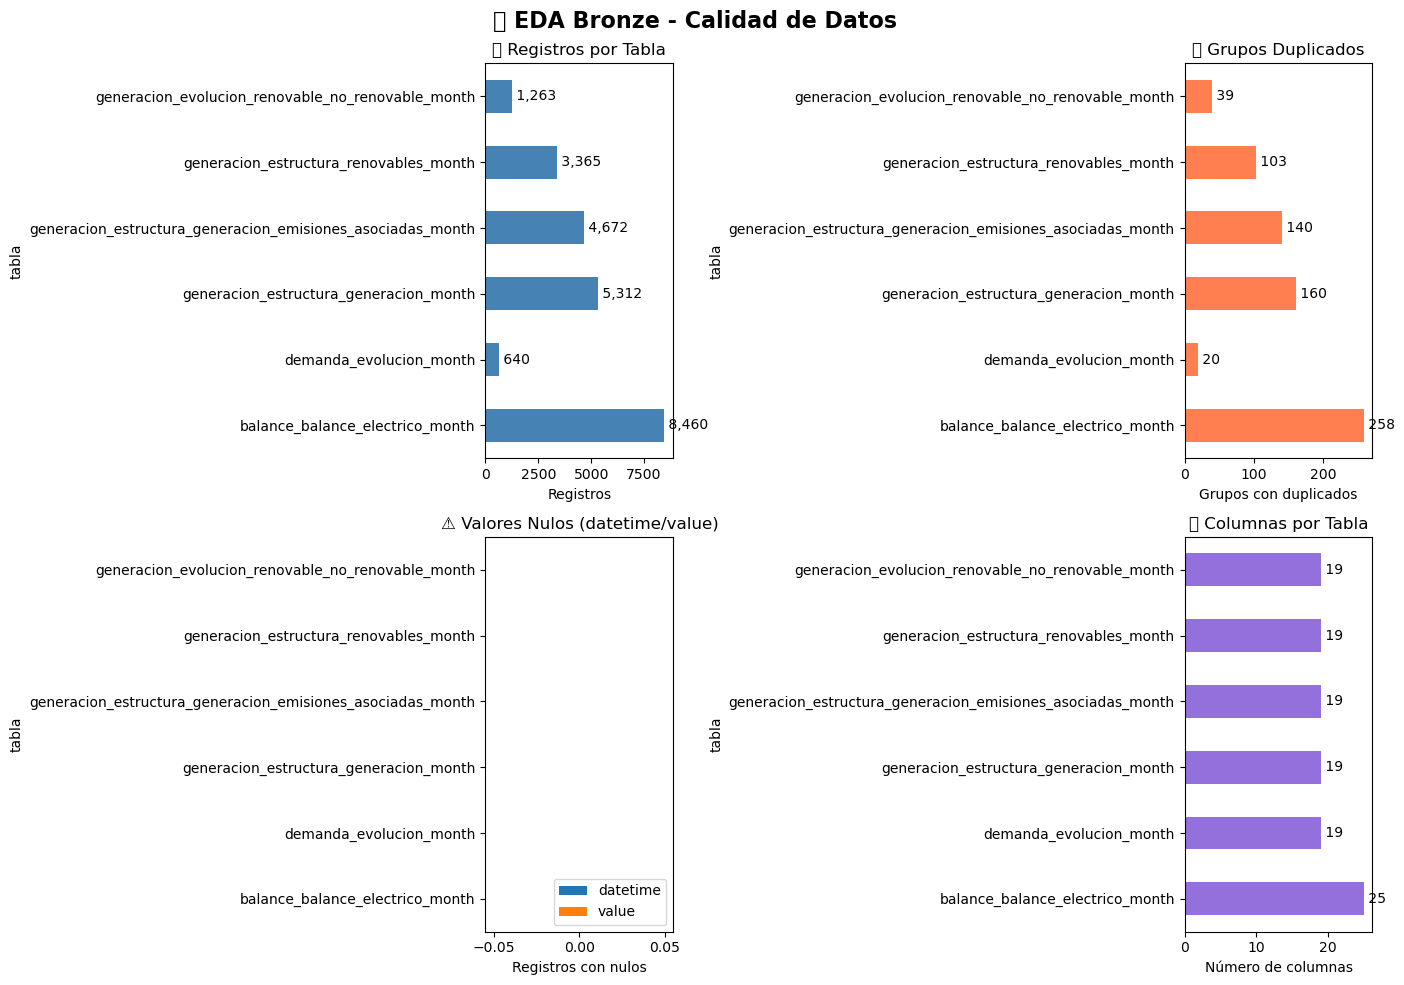

In [4]:
# ============================================
# 3. Visualización
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('🔍 EDA Bronze - Calidad de Datos', fontsize=16, fontweight='bold')

# 3.1 Registros por tabla
ax1 = axes[0, 0]
df_stats.plot(x='tabla', y='registros', kind='barh', ax=ax1, color='steelblue', legend=False)
ax1.set_title('📊 Registros por Tabla')
ax1.set_xlabel('Registros')
for i, v in enumerate(df_stats['registros']):
    ax1.text(v, i, f' {v:,}', va='center')

# 3.2 Duplicados detectados
ax2 = axes[0, 1]
df_stats.plot(x='tabla', y='duplicados', kind='barh', ax=ax2, color='coral', legend=False)
ax2.set_title('🔁 Grupos Duplicados')
ax2.set_xlabel('Grupos con duplicados')
for i, v in enumerate(df_stats['duplicados']):
    ax2.text(v, i, f' {v}', va='center')

# 3.3 Nulos en campos críticos
ax3 = axes[1, 0]
nulls_data = df_stats[['tabla', 'null_datetime', 'null_value']].set_index('tabla')
nulls_data.plot(kind='barh', ax=ax3, stacked=True)
ax3.set_title('⚠️ Valores Nulos (datetime/value)')
ax3.set_xlabel('Registros con nulos')
ax3.legend(['datetime', 'value'], loc='lower right')

# 3.4 Columnas por tabla
ax4 = axes[1, 1]
df_stats.plot(x='tabla', y='columnas', kind='barh', ax=ax4, color='mediumpurple', legend=False)
ax4.set_title('📋 Columnas por Tabla')
ax4.set_xlabel('Número de columnas')
for i, v in enumerate(df_stats['columnas']):
    ax4.text(v, i, f' {v}', va='center')

plt.tight_layout()
plt.show()

In [5]:
# ============================================
# 4. Resumen Ejecutivo
# ============================================
print("\n" + "="*60)
print("📊 RESUMEN BRONZE")
print("="*60)

total_records = df_stats['registros'].sum()
total_dups = df_stats['duplicados'].sum()
total_nulls = df_stats['null_datetime'].sum() + df_stats['null_value'].sum()

print(f"\n✅ Total registros: {total_records:,}")
print(f"🔁 Grupos con duplicados: {total_dups:,}")
print(f"⚠️  Valores nulos críticos: {total_nulls:,}")

if total_dups > 0:
    print(f"\n⚡ ACCIÓN REQUERIDA:")
    print(f"   → {total_dups} grupos duplicados necesitan limpieza en Silver")
    
print(f"\n📅 Rango temporal:")
print(f"   Desde: {df_stats['fecha_min'].min()}")
print(f"   Hasta: {df_stats['fecha_max'].max()}")

StatementMeta(, 621160ab-d8c3-4a94-b72e-11fefc585a83, 7, Finished, Available, Finished)


📊 RESUMEN BRONZE

✅ Total registros: 23,712
🔁 Grupos con duplicados: 720
⚠️  Valores nulos críticos: 0

⚡ ACCIÓN REQUERIDA:
   → 720 grupos duplicados necesitan limpieza en Silver

📅 Rango temporal:
   Desde: 2023-01-01 00:00:00
   Hasta: 2025-10-01 00:00:00


In [6]:
# ============================================
# 5. Ejemplo: Inspección de Duplicados
# ============================================
print("\n" + "="*60)
print("🔍 EJEMPLO: Duplicados en Balance Eléctrico")
print("="*60)

df_balance = spark.table(f"{LAKEHOUSE}.brz_redata_balance_balance_electrico_month")
keys = ["geo_id", "datetime", "series_type", "metric_type"]

duplicates = df_balance.groupBy(keys).agg(count("*").alias("count")) \
    .filter(col("count") > 1) \
    .orderBy(col("count").desc()) \
    .limit(5)

print("\nTop 5 grupos con más duplicados:")
duplicates.show(truncate=False)

# Ejemplo de un grupo duplicado
sample = duplicates.first()
if sample:
    print(f"\n📋 Detalle de un grupo duplicado:")
    df_balance.filter(
        (col("geo_id") == sample.geo_id) &
        (col("datetime") == sample.datetime) &
        (col("series_type") == sample.series_type) &
        (col("metric_type") == sample.metric_type)
    ).select("geo_id", "datetime", "series_type", "metric_type", 
             "value", "ingestion_timestamp").show(truncate=False)
    
    print("\n💡 Nota: Silver mantendrá el registro con ingestion_timestamp más reciente")

print("\n✅ EDA Bronze completado")

StatementMeta(, 621160ab-d8c3-4a94-b72e-11fefc585a83, 8, Finished, Available, Finished)


🔍 EJEMPLO: Duplicados en Balance Eléctrico

Top 5 grupos con más duplicados:
+------+-------------------+--------------+----------------------+-----+
|geo_id|datetime           |series_type   |metric_type           |count|
+------+-------------------+--------------+----------------------+-----+
|15    |2024-01-01 00:00:00|Almacenamiento|Turbinación bombeo    |2    |
|9     |2024-01-01 00:00:00|No-Renovable  |Nuclear               |2    |
|4     |2024-01-01 00:00:00|Renovable     |Solar térmica         |2    |
|7     |2024-01-01 00:00:00|Almacenamiento|Carga batería         |2    |
|15    |2024-01-01 00:00:00|No-Renovable  |Residuos no renovables|2    |
+------+-------------------+--------------+----------------------+-----+


📋 Detalle de un grupo duplicado:
+------+-------------------+--------------+------------------+----------+--------------------------+
|geo_id|datetime           |series_type   |metric_type       |value     |ingestion_timestamp       |
+------+-------------------+